In [34]:
import numpy as np 
import pandas as pd 
import sys 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '/data/jlu/OR_learning/utils')
import voxel_functions as vf
import color_function as cf 
import plot_functions as pf 

### Loading voxels 

In [70]:
# Open pickle file of binding cavity dictionary
Cbc_cav_coords = pd.read_pickle('/data/jlu/OR_learning/files/binding_cavity/dict_Cbc_cav_coords.pkl')
Cbc_res_coords = pd.read_pickle('/data/jlu/OR_learning/files/binding_cavity/dict_Cbc_res_coords.pkl')
# Response distance 
respDist = pd.read_csv('../../files/Deorphanization/Resp_Olfr_distance.csv', index_col = [0,1])[['resp_dist']]
# Remove 'Olfr' 
respDist = respDist[(~respDist.index.get_level_values(0).str.contains('Olfr')) &
                    (~respDist.index.get_level_values(1).str.contains('Olfr'))].sort_index()

In [151]:
# Create cavity voxels from coordinates 

# Make Cbc coords reordered with respDist index orders
OR_ORDER = np.sort(list(set.intersection(set(respDist.index.get_level_values(0).unique()), 
                                         set(Cbc_cav_coords.keys()))))

# Remove none intersected ORs from y
respDist = respDist[respDist.index.get_level_values(0).isin(OR_ORDER) & 
                    respDist.index.get_level_values(1).isin(OR_ORDER)]


Cbc_cav_coords = {_OR : Cbc_cav_coords[_OR] for _OR in OR_ORDER}
Cbc_res_coords = {_OR : Cbc_res_coords[_OR] for _OR in OR_ORDER}

# Voxelize binding cavity coordinates 
voxelized_Cbc, voxel_shape = vf.voxelize_cavity(list(Cbc_cav_coords.values()), 
                                                     list(Cbc_res_coords.values()), 
                                                     resolution=1)

# Output: List of 1D arrays representing voxelized space
print(np.array(voxelized_Cbc).shape)

(372, 41, 40, 36, 8)


### Quick Voxel visualization 

In [ ]:
# Visualize voxel 
colormap = cf.distinct_colors(list(Cbc_cav_coords.keys())[0:2])

fig = pf.visualize_voxel_grid(list(voxelized_Cbc[0:2]), 
                              coordinate_labels=list(Cbc_cav_coords.keys())[0:2], 
                              color_map=colormap, 
                              opacity=0.3)
# Update layout for 3D visualization
fig.show()


### CNN 

In [259]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a dataset class for pairwise voxel comparison
class PairwiseVoxelDataset(Dataset):
    def __init__(self, voxel, y_values, or_order):
        """
        Args:
            voxel: Voxelized cavities as a numpy array.
            y_values: DataFrame with pairwise response distances.
            or_order: List of receptor names in the order of voxel data.
        """
        self.voxel = voxel
        self.index_pairs = y_values.index  # Pair indices
        self.y_values = y_values.values  # Pairwise similarity scores
        self.or_order = or_order

    def __len__(self):
        return len(self.y_values)

    def __getitem__(self, idx):
        # Get the receptor pair indices
        or1, or2 = self.index_pairs[idx]

        # Convert receptor names to voxel indices
        idx1 = self.or_order.index(or1)
        idx2 = self.or_order.index(or2)

        # Get voxel data for the pair
        voxel1 = self.voxel[idx1]
        voxel2 = self.voxel[idx2]

        # Permute voxel dimensions to match Conv3d input format
        voxel1 = torch.tensor(voxel1, dtype=torch.float32).permute(3, 0, 1, 2)  # (channels, depth, height, width)
        voxel2 = torch.tensor(voxel2, dtype=torch.float32).permute(3, 0, 1, 2)

        # Get the similarity score
        y = self.y_values[idx]

        # Return tensors
        return voxel1, voxel2, torch.tensor(y, dtype=torch.float32)


# Initialize the dataset and dataloader
dataset = PairwiseVoxelDataset(voxelized_Cbc, respDist['resp_dist'], list(OR_ORDER))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [257]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Pairwise3DCNN(nn.Module):
    def __init__(self, input_channels=8):
        super(Pairwise3DCNN, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv3d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 20 * 20 * 18 * 2, 128)  # Output size after pooling and concatenation
        self.fc2 = nn.Linear(128, 1)  # Final similarity score

    def forward(self, x1, x2):
        # Pass first voxel through convolutional layers
        x1 = F.relu(self.conv1(x1))
        x1 = self.pool(F.relu(self.conv2(x1)))

        # Pass second voxel through convolutional layers
        x2 = F.relu(self.conv1(x2))
        x2 = self.pool(F.relu(self.conv2(x2)))

        # Flatten and concatenate features from both inputs
        x1 = torch.flatten(x1, start_dim=1)
        x2 = torch.flatten(x2, start_dim=1)
        x = torch.cat((x1, x2), dim=1)

        # Fully connected layers for final similarity score
        x = F.relu(self.fc1(x))
        similarity = self.fc2(x)
        return similarity

 10%|█         | 1/10 [00:46<07:00, 46.74s/it]

Epoch [1/10], Loss: 6.2203


 20%|██        | 2/10 [01:32<06:08, 46.07s/it]

Epoch [2/10], Loss: 0.0355


 30%|███       | 3/10 [02:19<05:24, 46.41s/it]

Epoch [3/10], Loss: 0.0352


 40%|████      | 4/10 [03:03<04:34, 45.76s/it]

Epoch [4/10], Loss: 0.0350


 50%|█████     | 5/10 [03:48<03:46, 45.22s/it]

Epoch [5/10], Loss: 0.0348


 60%|██████    | 6/10 [04:33<03:01, 45.38s/it]

Epoch [6/10], Loss: 0.0347


 70%|███████   | 7/10 [05:19<02:16, 45.57s/it]

Epoch [7/10], Loss: 0.0346


 80%|████████  | 8/10 [06:08<01:32, 46.41s/it]

Epoch [8/10], Loss: 0.0345


 90%|█████████ | 9/10 [06:53<00:46, 46.00s/it]

Epoch [9/10], Loss: 0.0345


100%|██████████| 10/10 [07:37<00:00, 45.77s/it]

Epoch [10/10], Loss: 0.0345


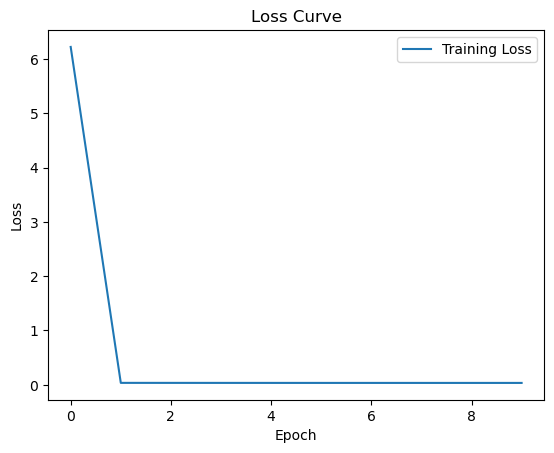

In [279]:
from torch.utils.data import Subset

# Randomly select a subset of indices
subset_indices = torch.randperm(len(dataset))[:200]  # Use 100 samples for quick training
small_dataset = Subset(dataset, subset_indices)

# Create DataLoader for the smaller dataset
small_dataloader = DataLoader(small_dataset, batch_size=8, shuffle=True)

import matplotlib.pyplot as plt

# Training parameters
num_epochs = 10  # Fewer epochs for quick testing
learning_rate = 0.001

# Initialize model, loss, and optimizer
model = Pairwise3DCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Store losses for visualization
losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    model.train()
    
    for voxel1, voxel2, y in small_dataloader:
        voxel1, voxel2, y = voxel1.to(device), voxel2.to(device), y.to(device)

        # Forward pass
        outputs = model(voxel1, voxel2).squeeze()
        loss = criterion(outputs, y)
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Log average loss for the epoch
    avg_loss = epoch_loss / len(small_dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot the loss curve
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [ ]:
from tqdm import tqdm 

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pairwise3DCNN(input_channels=8).to(device)
criterion = nn.MSELoss()  # Mean squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for voxel1, voxel2, y in dataloader:
        # Move data to device
        voxel1, voxel2, y = voxel1.to(device), voxel2.to(device), y.to(device)

        # Forward pass
        outputs = model(voxel1, voxel2).squeeze()
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

    # Print epoch loss
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [280]:
# Calculate MSE on the validation set
from sklearn.metrics import mean_squared_error

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for voxel1, voxel2, y in small_dataloader:
        voxel1, voxel2, y = voxel1.to(device), voxel2.to(device), y.to(device)
        outputs = model(voxel1, voxel2).squeeze()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

mse = mean_squared_error(y_true, y_pred)
print(f"Validation MSE: {mse:.4f}")

Validation MSE: 0.0345


R² Score: -0.0007


/data/jlu/OR_learning/utils/plot_functions.py:97: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



<module 'matplotlib.pyplot' from '/data/jlu/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

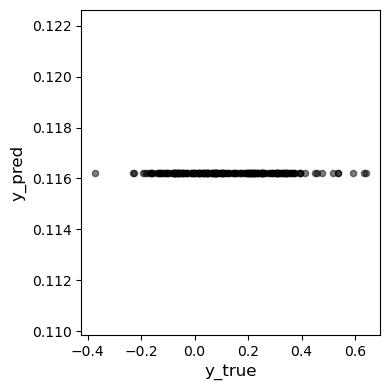

In [281]:
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.4f}")

pf.plot_correlation(y_true, y_pred, 
                    xlabel='y_true', ylabel='y_pred', 
                    opacity=0.5, 
                    plot_pearson_line=None, 
                    edgecolor='black', edgesize=20, 
                    figsize=[4,4])

In [ ]:
def visualize_feature_maps(layer, voxel):
    model.eval()
    with torch.no_grad():
        feature_map = layer(voxel.unsqueeze(0).to('cpu')).squeeze().cpu().numpy()

    # Visualize feature maps (first few channels)
    for i in range(min(4, feature_map.shape[0])):
        plt.imshow(feature_map[i].mean(axis=-1))  # Collapse along one axis
        plt.title(f"Feature Map Channel {i+1}")
        plt.colorbar()
        plt.show()

voxel_sample = dataset[0][0]  # A sample voxel
visualize_feature_maps(model.conv1, voxel_sample)